# Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pprint
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.signal import find_peaks
import ipywidgets as wg
from IPython.display import display, HTML
import sys

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Parameters

In [21]:
repo_path = "/home/deskema/VictorM/TCC_Biomec/"

# Specify reference path
ref_name = "Celio_Tecnica1"
video_path_ref = repo_path + "Videos/" + ref_name + ".avi"
vidprocessed_path_ref = repo_path + "Data/" + ref_name + "/" + ref_name + "BIK.mp4"
data_path_ref = repo_path + "Data/" + ref_name + "/" + ref_name + "BIK.data"

# Specify reference path
target_name = "Victor_Tecnica1"
video_path_target = repo_path + "Videos/" + target_name + ".avi"
vidprocessed_path_target = repo_path + "Data/" + target_name + "/" + target_name + "BIK.mp4"
data_path_target = repo_path + "Data/" + target_name + "/" + target_name + "BIK.data"

colors_2 = [[0,0,0], [0,255,0], [255,0,0], [0,0,255], [0,255,255],[255,255,0], 
         [255,0,255], [0,255,0], [255,200,100], [200,255,100],
         [100,255,200], [255,100,200], [100,200,255], [200,100,255],
         [200,200,0], [200,0,200],[0,200,200]]

# Functions

## Pose Estimation

In [23]:
def readAllFramesDATA(file_path):
    keypoints_vec = []
    angles_vec = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i==0:
                metadata = json.loads(line)
            else:
                data = json.loads(line)
                keypoints_vec.append(data["keypoints"])
                angles_vec.append(data["angles"])
    keypoints_vec = np.array(keypoints_vec).astype(float)
    angles_vec = np.array(angles_vec).astype(float)
    return metadata, keypoints_vec, angles_vec

def poseDATAtoFrame(frame, pose_keypoints, persons, joint_names, pairs_names, thickness=3, color = -1):
    try:
        single = False
        if persons == 0:
            persons = [0]
            single = True
        if persons == -1:
            persons = np.arange(pose_keypoints.shape[0])

    except IndexError:
        return frame

    try:
        for n in persons:
            i = 0
            for pair in pairs_names:
                A_idx = joint_names.index(pair[0])
                B_idx = joint_names.index(pair[1])
                if single:
                    A = tuple(pose_keypoints[A_idx][:2].astype(int))
                    B = tuple(pose_keypoints[B_idx][:2].astype(int))
                else:
                    A = tuple(pose_keypoints[n][A_idx][:2].astype(int))
                    B = tuple(pose_keypoints[n][B_idx][:2].astype(int))
                if (0 in A) or (0 in B):
                    i+=1
                    continue
                if(color == -1):
                    cv2.line(frame, (A[0], A[1]), (B[0], B[1]), colors_25[i], thickness, cv2.LINE_AA)
                else:
                    cv2.line(frame, (A[0], A[1]), (B[0], B[1]), colors_2[color], thickness, cv2.LINE_AA)
                i+=1
    except IndexError:
        return frame
    return frame

def getFrame(video_name, n, allvid=False, input_path=False):
    if input_path:
        input_source = video_name
    else:
        if allvid:
            input_source = allvid_dir + video_name
        else:
            input_source = videos_dir + video_name
    
    cap = cv2.VideoCapture(input_source)
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)
    has_frame, image = cap.read()
    cap.release() 
    frame_width = image.shape[1]
    frame_height = image.shape[0]
    
    return image, frame_width, frame_height

def showFrame(frame, figsize=[9,6]):
    plt.figure(figsize=figsize)
    plt.imshow(frame[:,:,[2,1,0]])
    plt.axis("off")
    plt.show()

def showAnglesFrame(frame_ang, pose_keypoints, angles, thickness=3, textsize=2, adj=2):
    for i in range(len(angles)):
        A = pose_keypoints[i]
        B = pose_keypoints[i+1]
        D = (int(A[0]), int(A[1]))
        str_to_write = str(int(round(angles[i])))
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_len = cv2.getTextSize(str_to_write, font, textsize, thickness)[0]
        cv2.rectangle(frame_ang, (D[0]-adj, D[1]+adj), (D[0] + text_len[0]+adj, D[1] - text_len[1]-adj), (0,125,255), -1)
        cv2.putText(frame_ang, str_to_write, D, font, textsize,(0,0,0),thickness,cv2.LINE_AA)
        i+=1
    return frame_ang

def getAngleLimited(A, B, O):
    try:
        ang = math.degrees(math.atan2(B[1]-O[1], B[0]-O[0]) - math.atan2(A[1]-O[1], A[0]-O[0]))
        if ang < 0:
            ang += 360
        if ang > 180:
            ang = 360 - ang
    except:
        ang = 0
    return ang

def defineRowingPhases(video_path, n_frames, frame_no=0):
    cap = cv2.VideoCapture(video_path)
    pose_frame = [0,0,0,0,0]
    moment = 0
    if(cap.isOpened() == False):
        print("Error opening video stream or file")
        print(video_path)
        sys.exit(-1)
    while True:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret_val, img = cap.read()
        if ret_val:
            img = cv2.resize(img, (960, 540)) 
            cv2.imshow('Video Analysis', img)
        arg = cv2.waitKey(1)
        if arg == 27:
            break  # esc to quit
        elif arg == 13: # pressed enter
            pose_frame[moment] = frame_no
            moment = (moment+1)%5
            print(pose_frame)
        elif arg == 100:
            frame_no = (frame_no+1)%n_frames
        elif arg == 97:
            frame_no = (frame_no-1)%n_frames
    cap.release()
    cv2.destroyAllWindows()
    return pose_frame

def plotRowingMoments(angles_vec, pose_frame, fps, angles_names):
    rowing_phases = ['Catch', 'Leg Drive', 'Arm Drive', 'Arm Recovery', 'Leg Recovery']
    phases_colors = ['black', 'gray', 'red', 'green', 'purple']
    n0 = pose_frame[0]
    n1 = pose_frame[4]
    angle_knee = "Hip <- Knee -> Ankle"
    angle_elb = "Wrist <- Elbow -> Shoulder"
    angles_vec_knee = angles_vec[n0:n1+1, angles_names.index(angle_knee)]
    angles_vec_elb = angles_vec[n0:n1+1, angles_names.index(angle_elb)]
    time_vec_cycle = np.linspace(n0*(1/fps), n1*(1/fps), n1+1-n0)
    plt.figure()
    plt.plot(time_vec_cycle, angles_vec_knee, label='Knee')
    plt.plot(time_vec_cycle, angles_vec_elb, label='Elbow')
    for i in range(len(rowing_phases)):
        plt.scatter(time_vec_cycle[pose_frame[i]-pose_frame[0]], angles_vec_knee[pose_frame[i]-pose_frame[0]], 
                marker='o', color=phases_colors[i], label=rowing_phases[i])
        plt.scatter(time_vec_cycle[pose_frame[i]-pose_frame[0]], angles_vec_elb[pose_frame[i]-pose_frame[0]], 
                marker='o', color=phases_colors[i])
    plt.legend()
    plt.ylabel("Angle (degrees)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.show()

def compareRowingMoments(angles_vec_ref, pose_frame_ref, fps_ref, 
                         angles_vec_target, pose_frame_target, fps_target, 
                         angles_names):
    rowing_phases = ['Catch', 'Leg Drive', 'Arm Drive', 'Arm Recovery', 'Leg Recovery']
    phases_colors = ['black', 'gray', 'red', 'green', 'purple']
    angle_knee = "Hip <- Knee -> Ankle"
    angle_elb = "Wrist <- Elbow -> Shoulder"
    n0_ref, n0_target = pose_frame_ref[0], pose_frame_target[0]
    n1_ref, n1_target = pose_frame_ref[4], pose_frame_target[4]
    angles_vec_knee_ref = angles_vec_ref[n0_ref:n1_ref+1, angles_names.index(angle_knee)]
    angles_vec_elb_ref = angles_vec_ref[n0_ref:n1_ref+1, angles_names.index(angle_elb)]
    angles_vec_knee_target = angles_vec_target[n0_target:n1_target+1, angles_names.index(angle_knee)]
    angles_vec_elb_target = angles_vec_target[n0_target:n1_target+1, angles_names.index(angle_elb)]
    time_vec_cycle_ref = np.linspace(n0_ref*(1/fps_ref), n1_ref*(1/fps_ref), n1_ref+1-n0_ref) - n0_ref*(1/fps_ref)
    time_vec_cycle_target = np.linspace(n0_target*(1/fps_target), n1_target*(1/fps_target), n1_target+1-n0_target) - n0_target*(1/fps_target)
    plt.figure(figsize=[7,5])
    plt.plot(time_vec_cycle_ref, angles_vec_knee_ref, label='Ref Knee')
    plt.plot(time_vec_cycle_ref, angles_vec_elb_ref, label='Ref Elbow')
    plt.plot(time_vec_cycle_target, angles_vec_knee_target, label='Target Knee')
    plt.plot(time_vec_cycle_target, angles_vec_elb_target, label='Target Elbow')
    for i in range(len(rowing_phases)):
        plt.scatter(time_vec_cycle_ref[pose_frame_ref[i]-pose_frame_ref[0]], 
                    angles_vec_knee_ref[pose_frame_ref[i]-pose_frame_ref[0]], 
                    marker='o', color=phases_colors[i], label=rowing_phases[i])
        plt.scatter(time_vec_cycle_ref[pose_frame_ref[i]-pose_frame_ref[0]], 
                    angles_vec_elb_ref[pose_frame_ref[i]-pose_frame_ref[0]], 
                    marker='o', color=phases_colors[i])
        plt.scatter(time_vec_cycle_target[pose_frame_target[i]-pose_frame_target[0]], 
                    angles_vec_knee_target[pose_frame_target[i]-pose_frame_target[0]], 
                    marker='o', color=phases_colors[i])
        plt.scatter(time_vec_cycle_target[pose_frame_target[i]-pose_frame_target[0]], 
                    angles_vec_elb_target[pose_frame_target[i]-pose_frame_target[0]], 
                    marker='o', color=phases_colors[i])
    plt.title("Rowing Angles for One Cycle")
    plt.legend()
    plt.ylabel("Angle (degrees)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.show()
    
def compareSingleJointPhases(row_cycle_target, time_row_cycle_target, pose_frame_target,
                             pose_frame_estimated, angle_name='Knee'):
    
    rowing_phases = ['Catch GT', 'Leg Drive GT', 'Arm Drive GT', 'Arm Recovery GT', 'Leg Recovery GT']
    rowing_phases_est = ['Catch Est', 'Leg Drive Est', 'Arm Drive Est', 'Arm Recovery Est', 'Leg Recovery Est']
    phases_colors = ['black', 'gray', 'red', 'green', 'purple']
    plt.figure(figsize=[7,5])
    plt.plot(time_row_cycle_target, row_cycle_target)
    for i in range(len(rowing_phases)):
            plt.scatter(time_row_cycle_target[pose_frame_target[i]-pose_frame_target[0]], 
                        row_cycle_target[pose_frame_target[i]-pose_frame_target[0]], 
                        marker='o', color=phases_colors[i], label=rowing_phases[i])
            plt.scatter(time_row_cycle_target[pose_frame_estimated[i]-pose_frame_estimated[0]], 
                        row_cycle_target[pose_frame_estimated[i]-pose_frame_estimated[0]], 
                        marker='^', color=phases_colors[i], label=rowing_phases_est[i])
    plt.legend()
    plt.ylabel("Angle (degrees)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.show()
    
def showAnglesFrame(frame, pose_keypoints, angles, thickness=2, textsize=2, adj=8, alpha=1.0):
    frame_ang = frame.copy()
    for i in range(len(angles)):
        rect_color = (50,170,50) #(255,0,100)
        str_to_write = str(int(round(angles[i])))
        font = cv2.FONT_HERSHEY_DUPLEX
        text_len = cv2.getTextSize(str_to_write, font, textsize, thickness)[0]
        A = pose_keypoints[i]
        B = pose_keypoints[i+1]
        D = (int(A[0]), int(A[1]))
        if i==4:
            D = (int(A[0]) - int(text_len[0]/2), int(A[1]))
            cv2.rectangle(frame_ang, (D[0]-adj, D[1]+adj), (D[0] + text_len[0]+adj, D[1] - text_len[1]-adj), rect_color, -1)
            cv2.putText(frame_ang, str_to_write, D, font, textsize,(0,0,0),thickness,cv2.LINE_AA)
        elif i==1:
            D = (int(A[0]) - int(text_len[0]/2), int(A[1]) + int(text_len[1]))
            cv2.rectangle(frame_ang, (D[0]-adj, D[1]+adj), (D[0] + text_len[0]+adj, D[1] - text_len[1]-adj), rect_color, -1)
            cv2.putText(frame_ang, str_to_write, D, font, textsize,(0,0,0),thickness,cv2.LINE_AA)
        else:
            D = (int(A[0]) - int(text_len[0]/2), int(A[1]) + int(text_len[1]/2))
            cv2.rectangle(frame_ang, (D[0]-adj, D[1]+adj), (D[0] + text_len[0]+adj, D[1] - text_len[1]-adj), rect_color, -1)
            cv2.putText(frame_ang, str_to_write, D, font, textsize,(0,0,0),thickness,cv2.LINE_AA)
        i+=1
        # Following line overlays transparent rectangle over the image
    image_new = cv2.addWeighted(frame_ang, alpha, frame, 1 - alpha, 0)
    return image_new

def showAnglesRowing(frame, pose_keypoints, angles, thickness=2, textsize=2, adj=8, alpha=1.0, rect_color=(50,170,50), text_color=(0,0,0)):
    frame_ang = frame.copy()
    for i in range(len(angles)):
        str_to_write = str(int(round(angles[i])))
        font = cv2.FONT_HERSHEY_DUPLEX
        text_len = cv2.getTextSize(str_to_write, font, textsize, thickness)[0]
        A = pose_keypoints[i]
        B = pose_keypoints[i+1]
        D = (int(A[0]), int(A[1]))
        if i==4:
            D = (int(A[0]) - int(text_len[0]/2), int(A[1]))
            cv2.rectangle(frame_ang, (D[0]-adj, D[1]+adj), (D[0] + text_len[0]+adj, D[1] - text_len[1]-adj), rect_color, -1)
            cv2.putText(frame_ang, str_to_write, D, font, textsize,text_color,thickness,cv2.LINE_AA)
        elif i==1:
            D = (int(A[0]) - int(text_len[0]/2), int(A[1]) + int(text_len[1]))
            cv2.rectangle(frame_ang, (D[0]-adj, D[1]+adj), (D[0] + text_len[0]+adj, D[1] - text_len[1]-adj), rect_color, -1)
            cv2.putText(frame_ang, str_to_write, D, font, textsize,text_color,thickness,cv2.LINE_AA)
        else:
            D = (int(A[0]) - int(text_len[0]/2), int(A[1]) + int(text_len[1]/2))
            cv2.rectangle(frame_ang, (D[0]-adj, D[1]+adj), (D[0] + text_len[0]+adj, D[1] - text_len[1]-adj), rect_color, -1)
            cv2.putText(frame_ang, str_to_write, D, font, textsize,text_color,thickness,cv2.LINE_AA)
        i+=1
        # Following line overlays transparent rectangle over the image
    image_new = cv2.addWeighted(frame_ang, alpha, frame, 1 - alpha, 0)
    return image_new

## DTW

In [16]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Purples') 
    plt.gca().invert_yaxis()
    plt.xlabel("Reference")
    plt.ylabel("Target")
    plt.grid()
    plt.colorbar()
    
def euclidian_distances(time_seriesH, time_seriesV):    
    distances = np.zeros([len(time_seriesV), len(time_seriesH)]) # same length
    for i in range(len(time_seriesV)):
        for j in range(len(time_seriesH)):
            distances[i,j] = (time_seriesH[j]-time_seriesV[i])**2
    return distances

def get_accumulated_cost(time_seriesH, time_seriesV, distances):
    accumulated_cost = np.zeros((len(time_seriesV), len(time_seriesH)))

    for i in range(1, len(time_seriesH)): 
        accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1]
        for i in range(1, len(time_seriesV)):
            accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]
    for i in range(1, len(time_seriesV)):
        for j in range(1, len(time_seriesH)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

    path = [[len(time_seriesV)-1, len(time_seriesH)-1]]
    i = len(time_seriesH)-1 
    j = len(time_seriesV)-1
    while i > 0 and j > 0:
        if i == 0:
            j = j - 1
        elif j == 0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j - 1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    path_x = [point[0] for point in path] # time_seriesH
    path_z = [point[1] for point in path] # time_seriesV
    return accumulated_cost, path_x, path_z


def path_cost(time_seriesH, time_seriesV, accumulated_cost, distances):
    path = [[len(time_seriesH)-1, len(time_seriesV)-1]]
    cost = 0
    i = len(time_seriesV)-1
    j = len(time_seriesH)-1
    while i > 0 and j > 0:
        if i == 0:
            j = j - 1
        elif j == 0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [time_seriesV, time_seriesH] in path:
        cost = cost + distances[time_seriesH, time_seriesV]
    return path, cost

def plotDTWPaths(row_cycle_ref, row_cycle_target, time_row_cycle_ref, time_row_cycle_target, paths):
    plt.figure()
    for (map_row_cycle_ref, map_row_cycle_target) in paths:
        plt.plot([time_row_cycle_target[map_row_cycle_target], time_row_cycle_ref[map_row_cycle_ref]], [row_cycle_target[map_row_cycle_target], row_cycle_ref[map_row_cycle_ref]], 'r')
    plt.plot(time_row_cycle_target, row_cycle_target, color = 'b', label = 'Target', linewidth=5)
    plt.plot(time_row_cycle_ref, row_cycle_ref, color = 'g',  label = 'Reference', linewidth=5)
    plt.legend()
    plt.ylabel("Angle (degrees)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.show()

# Set Reference Data

<font color='red'>OBS: To change reference video go to the Parameters section</font>

In [17]:
# Import data
metadata_ref, keypoints_vec_ref, angles_vec_ref = readAllFramesDATA(data_path_ref)
fps_ref = metadata_ref["fps"]
time_vec_ref = np.linspace(0, len(angles_vec_ref)*(1/fps_ref), len(angles_vec_ref))
joint_names = metadata_ref["keypoints_names"]
pairs_names = metadata_ref["keypoints_pairs"]
n_frames_ref = metadata_ref["n_frames"]
angles_names = ["Knee <- Ankle -> Ground", "Hip <- Knee -> Ankle", "Shoulder <- Hip -> Knee", "Elbow <- Shoulder -> Hip", "Wrist <- Elbow -> Shoulder"]

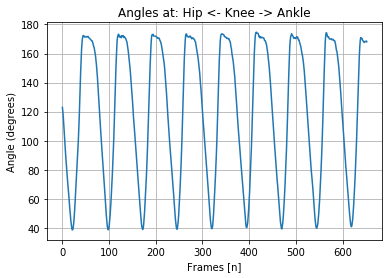

In [18]:
# Plot Angle
angle_name = "Hip <- Knee -> Ankle" # Joint name
plt.figure()
plt.plot(angles_vec_ref[:, angles_names.index(angle_name)])
plt.title("Angles at: {}".format(angle_name))
plt.ylabel("Angle (degrees)")
plt.xlabel("Frames [n]")
plt.grid(True)
plt.show()

In [19]:
#pose_frame_ref = defineRowingPhases(vidprocessed_path_ref, n_frames_ref, frame_no=300)
pose_frame_ref = [322, 339, 344, 364, 395]

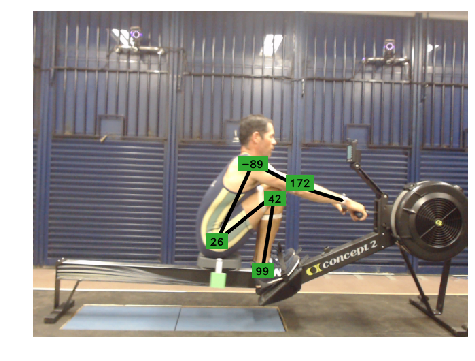

In [24]:
frame, frame_width, frame_height = getFrame(video_path_ref, pose_frame_ref[0], input_path=True)
angles = angles_vec_ref[pose_frame_ref[0]]
pose_keypoints = keypoints_vec_ref[pose_frame_ref[0]]
image = poseDATAtoFrame(frame, pose_keypoints, 0, joint_names, pairs_names, color=0)
angles_image = showAnglesRowing(image, pose_keypoints, angles, thickness=1, textsize=0.5, adj=5, alpha=1.0)
showFrame(angles_image, save=True)

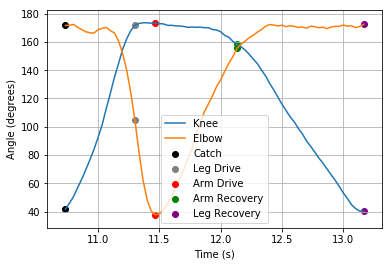

In [26]:
plotRowingMoments(angles_vec_ref, pose_frame_ref, fps_ref, angles_names)

# Set Target Data

<font color='red'>OBS: To change target video go to the Parameters section</font>

In [27]:
# Import data
metadata_target, keypoints_vec_target, angles_vec_target = readAllFramesDATA(data_path_target)
fps_target = metadata_target["fps"]
time_vec_target = np.linspace(0, len(angles_vec_target)*(1/fps_target), len(angles_vec_target))
joint_names = metadata_target["keypoints_names"]
pairs_names = metadata_target["keypoints_pairs"]
n_frames_target = metadata_target["n_frames"]
angles_names = ["Knee <- Ankle -> Ground", "Hip <- Knee -> Ankle", "Shoulder <- Hip -> Knee", "Elbow <- Shoulder -> Hip", "Wrist <- Elbow -> Shoulder"]

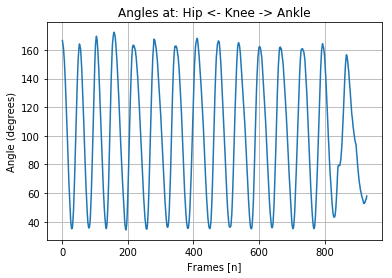

In [28]:
# Plot Angle
angle_name = "Hip <- Knee -> Ankle" # Joint name
plt.figure()
plt.plot(angles_vec_target[:, angles_names.index(angle_name)])
plt.title("Angles at: {}".format(angle_name))
plt.ylabel("Angle (degrees)")
plt.xlabel("Frames [n]")
plt.grid(True)
plt.show()

In [29]:
#pose_frame_target = defineRowingPhases(vidprocessed_path_target, n_frames_target, frame_no=400)
pose_frame_target = [283, 313, 318, 331, 346]

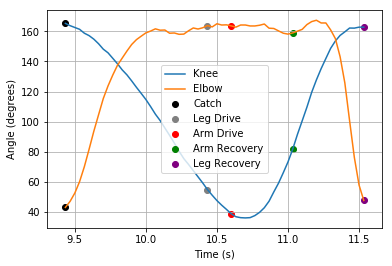

In [30]:
plotRowingMoments(angles_vec_target, pose_frame_target, fps_target, angles_names)

# Compare Target and Reference

In [16]:
angle_knee = "Hip <- Knee -> Ankle"
angle_elb = "Wrist <- Elbow -> Shoulder"
n0_ref, n0_target = pose_frame_ref[0], pose_frame_target[0]
n1_ref, n1_target = pose_frame_ref[4], pose_frame_target[4]
angles_vec_knee_ref = angles_vec_ref[n0_ref:n1_ref+1, angles_names.index(angle_knee)]
angles_vec_elb_ref = angles_vec_ref[n0_ref:n1_ref+1, angles_names.index(angle_elb)]
angles_vec_knee_target = angles_vec_target[n0_target:n1_target+1, angles_names.index(angle_knee)]
angles_vec_elb_target = angles_vec_target[n0_target:n1_target+1, angles_names.index(angle_elb)]
time_vec_cycle_ref = np.linspace(n0_ref*(1/fps_ref), n1_ref*(1/fps_ref), n1_ref+1-n0_ref) - n0_ref*(1/fps_ref)
time_vec_cycle_target = np.linspace(n0_target*(1/fps_target), n1_target*(1/fps_target), n1_target+1-n0_target) - n0_target*(1/fps_target)

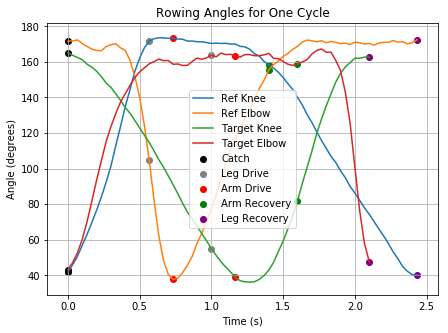

In [17]:
compareRowingMoments(angles_vec_ref, pose_frame_ref, fps_ref, 
                         angles_vec_target, pose_frame_target, fps_target, 
                         angles_names)

# DTW Library

In [18]:
distance_knee, paths_knee = fastdtw(angles_vec_knee_ref, angles_vec_knee_target, dist=euclidean)
distance_elb, paths_elb = fastdtw(angles_vec_elb_ref, angles_vec_elb_target, dist=euclidean)
paths_knee = np.array(paths_knee)
paths_elb = np.array(paths_elb)

In [20]:
distance_elb

2536.2621487646607

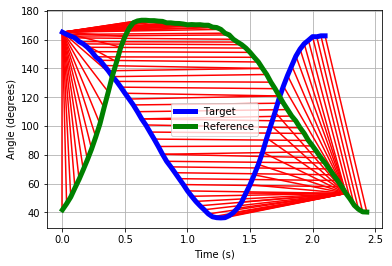

In [21]:
%matplotlib inline
plotDTWPaths(angles_vec_knee_ref, angles_vec_knee_target, time_vec_cycle_ref, time_vec_cycle_target, paths_knee)

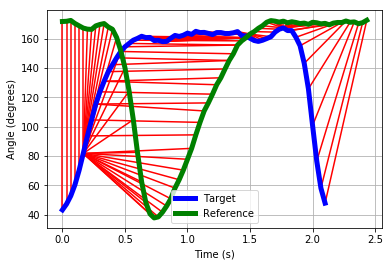

In [22]:
%matplotlib inline
plotDTWPaths(angles_vec_elb_ref, angles_vec_elb_target, time_vec_cycle_ref, time_vec_cycle_target, paths_elb)

# Single Cycle Automatic Analysis

### Get Corresponding Phases

In [51]:
estimated_targets = [0, 0, 0, 0, len(angles_vec_knee_target)-1]
i=1
idx_path = np.mean(np.where(paths_elb[:, 0] == pose_frame_ref[i] - pose_frame_ref[0])[0]).astype(int)
idx_target = paths_knee[idx_path, 1]
estimated_targets[i] = idx_target
for i in (2,3):
    idx_path = np.mean(np.where(paths_elb[:, 0] == pose_frame_ref[i] - pose_frame_ref[0])[0]).astype(int)
    idx_target = paths_elb[idx_path, 1]
    estimated_targets[i] = idx_target
print("Estimated:    ", np.array(estimated_targets))
print("Ground Truth: ", np.array(pose_frame_target) - pose_frame_target[0])

Estimated:     [ 0 24 28 41 66]
Ground Truth:  [ 0 22 27 42 66]


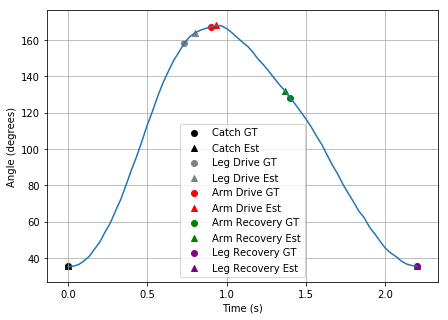

In [52]:
compareSingleJointPhases(angles_vec_knee_target, time_vec_cycle_target, pose_frame_target, estimated_targets, angle_name='Knee')

### Analysis Interface

In [54]:
rowing_phases = ['Catch', 'Leg Drive', 'Arm Drive', 'Arm Recovery', 'Leg Recovery']
def showRowingPhase(row_phase):  
    tab_len = 750
    title_color = (255,255,255)
    info_color = (50,170,50)
    frame_n = estimated_targets[rowing_phases.index(row_phase)] + pose_frame_target[0]
    frame, frame_width, frame_height = getFrame(video_path_target, frame_n)
    angles = angles_vec_target[frame_n]
    pose_keypoints = keypoints_vec_target[frame_n]
    image = poseDATAtoFrame(frame, pose_keypoints, joint_names, pairs_names)
    angles_image = showAnglesFrame(image, pose_keypoints, angles, thickness=3, textsize=1.2)
    data_image = np.zeros([angles_image.shape[0], angles_image.shape[1] + tab_len, angles_image.shape[2]])
    data_image[:, :angles_image.shape[1], :] = angles_image
    text_thickness = 6
    cv2.putText(data_image, "Cycle Analysis".format(frame_n*(1/fps_target)), 
                (angles_image.shape[1]+60,70), cv2.FONT_HERSHEY_COMPLEX, 2.5, title_color, text_thickness)
    cv2.putText(data_image, "Video Time: {0:.2f} s".format(frame_n*(1/fps_target)), 
                (angles_image.shape[1]+30,1*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    cv2.putText(data_image, "Cycle Time: {0:.2f} s".format((frame_n-pose_frame_target[0])*(1/fps_target)), 
                (angles_image.shape[1]+30,2*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    cycle_period = (pose_frame_target[4]-pose_frame_target[0])*(1/fps_target)
    cv2.putText(data_image, "Period: {0:.2f} s".format(cycle_period), 
                (angles_image.shape[1]+30,3*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    pace_spm = round(60*fps_target/(pose_frame_target[4] - pose_frame_target[0]))
    cv2.putText(data_image, "Pace: {} s/m".format(pace_spm), 
                (angles_image.shape[1]+30,4*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    drive_time = (pose_frame_target[2]-pose_frame_target[0])*(1/fps_target)
    drive_pct = round(100*drive_time/cycle_period)
    cv2.putText(data_image, "Drive: {} %".format(drive_pct), 
                (angles_image.shape[1]+30,5*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    recovery_pct = 100-drive_pct
    cv2.putText(data_image, "Recovery: {} %".format(recovery_pct), 
                (angles_image.shape[1]+30,6*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    score = 10
    cv2.putText(data_image, "Score: {}".format(score), 
                (angles_image.shape[1]+30,7*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    showFrame(data_image.astype(int), figsize=[12,8])

phase_dp = wg.Dropdown(options=rowing_phases,
                        value='Catch',
                        description='Phase: ',
                        disabled=False)

out_rp = wg.interactive_output(showRowingPhase, {'row_phase': phase_dp})

display(phase_dp, out_rp)

Dropdown(description='Phase: ', options=('Catch', 'Leg Drive', 'Arm Drive', 'Arm Recovery', 'Leg Recovery'), v…

Output()

# All Cycles Automatic Analysis

## Used Reference

<font color='red'>OBS: To change go to the set reference section</font>

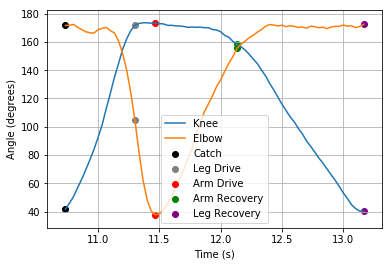

In [56]:
angles_vec_knee_ref = angles_vec_ref[:, angles_names.index(angle_knee)]
angles_vec_elb_ref = angles_vec_ref[:, angles_names.index(angle_elb)]
plotRowingMoments(angles_vec_ref, pose_frame_ref, fps_ref, angles_names)

## Rowing Technique Analyzed

<font color='red'>OBS: To change go to the set target section</font>

In [57]:
angle_knee = "Hip <- Knee -> Ankle"
angle_elb = "Wrist <- Elbow -> Shoulder"
angles_vec_knee_target = angles_vec_target[:, angles_names.index(angle_knee)]
angles_vec_elb_target = angles_vec_target[:, angles_names.index(angle_elb)]
time_vec_cycle_target = np.linspace(0, len(angles_vec_knee_target)*(1/fps_target), len(angles_vec_knee_target))

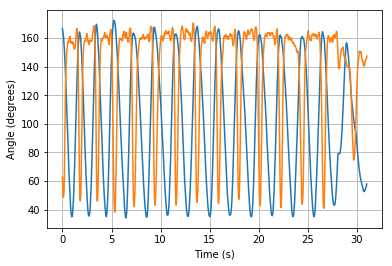

In [58]:
# Plot Angle
plt.figure()
plt.plot(time_vec_cycle_target, angles_vec_knee_target)
plt.plot(time_vec_cycle_target, angles_vec_elb_target)
plt.ylabel("Angle (degrees)")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

## Segmenting Cycles Using the Knee Angle

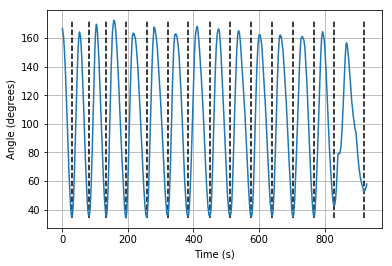

In [59]:
peaks, properties = find_peaks(-angles_vec_knee_target, height=-60)
plt.plot(angles_vec_knee_target)
plt.vlines(x=peaks, ymin=min(angles_vec_knee_target), 
           ymax = max(angles_vec_knee_target), color = "black", linestyles ='dashed')
plt.ylabel("Angle (degrees)")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

In [64]:
row_cycles = []
for i in range(1, len(peaks)):
    row_cycles.append(np.array(angles_vec_target[peaks[i-1]-1:peaks[i],:]))

In [65]:
def f(n):
    plt.figure()
    for i in range(len(angles_names)):
        plt.plot(row_cycles[n][:,i], label=angles_names[i])
    plt.legend()
    plt.grid(True)
    plt.ylabel("Angle (degrees)")
    plt.xlabel("Frame [n]")
    plt.show()
    
cycle = wg.IntSlider(description='cycle number', max=len(row_cycles)-1, continuous_update=False)
out = wg.interactive_output(f, {'n': cycle})

display(cycle, out)

IntSlider(value=0, continuous_update=False, description='cycle number', max=13)

Output()

## Applying DTW to every cycle

In [62]:
estimated_cycles = []
for n in range(len(row_cycles)):
    _, paths_knee = fastdtw(angles_vec_knee_ref, row_cycles[n][:,angles_names.index(angle_knee)], dist=euclidean)
    _, paths_elb = fastdtw(angles_vec_elb_ref, row_cycles[n][:,angles_names.index(angle_elb)], dist=euclidean)
    paths_knee = np.array(paths_knee)
    paths_elb = np.array(paths_elb)
    estimated_targets = [0, 0, 0, 0, len(row_cycles[n][:,angles_names.index(angle_knee)])-1]
    i=1
    idx_path = np.mean(np.where(paths_elb[:, 0] == pose_frame_ref[i] - pose_frame_ref[0])[0]).astype(int)
    idx_target = paths_knee[idx_path, 1]
    estimated_targets[i] = idx_target
    for i in (2,3):
        idx_path = np.mean(np.where(paths_elb[:, 0] == pose_frame_ref[i] - pose_frame_ref[0])[0]).astype(int)
        idx_target = paths_elb[idx_path, 1]
        estimated_targets[i] = idx_target
    estimated_cycles.append(estimated_targets)

In [63]:
def interactiveRowingMoments(n):
    plotRowingMoments(row_cycles[n], estimated_cycles[n], fps_target, angles_names)
    
cycle = wg.IntSlider(description='cycle number', max=len(row_cycles)-1, continuous_update=False)
out = wg.interactive_output(interactiveRowingMoments, {'n': cycle})
display(cycle, out)

IntSlider(value=0, continuous_update=False, description='cycle number', max=13)

Output()

## Interactive Interface for Training

In [ ]:
rowing_phases = ['Catch', 'Leg Drive', 'Arm Drive', 'Arm Recovery', 'Leg Recovery']
def showRowingPhaseTraining(row_phase, cycle_n, frame_n):  
    tab_len = 750
    title_color = (255,255,255)
    info_color = (50,170,50)
    text_thickness = 6
    
    frame, frame_width, frame_height = getFrame(video_path_target, frame_n)
    angles = angles_vec_target[frame_n]
    pose_keypoints = keypoints_vec_target[frame_n]
    image = poseDATAtoFrame(frame, pose_keypoints, joint_names, pairs_names)
    angles_image = showAnglesFrame(image, pose_keypoints, angles, thickness=3, textsize=1.2)
    
    data_image = np.zeros([angles_image.shape[0], angles_image.shape[1] + tab_len, angles_image.shape[2]])
    data_image[:, :angles_image.shape[1], :] = angles_image[:,:,:]

    cv2.putText(data_image, "Cycle Analysis".format(frame_n*(1/fps_target)), 
                (angles_image.shape[1]+60,70), cv2.FONT_HERSHEY_COMPLEX, 2.5, title_color, text_thickness)
    cv2.putText(data_image, "Video Time: {0:.2f} s".format(frame_n*(1/fps_target)), 
                (angles_image.shape[1]+30,1*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    cv2.putText(data_image, "Cycle Time: {0:.2f} s".format((frame_n-peaks[cycle_n])*(1/fps_target)), 
                (angles_image.shape[1]+30,2*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    cycle_period = (estimated_cycles[cycle_n][4]-estimated_cycles[cycle_n][0])*(1/fps_target)
    cv2.putText(data_image, "Period: {0:.2f} s".format(cycle_period), 
                (angles_image.shape[1]+30,3*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    pace_spm = round(60/cycle_period)
    cv2.putText(data_image, "Pace: {} s/m".format(pace_spm), 
                (angles_image.shape[1]+30,4*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    drive_time = (estimated_cycles[cycle_n][2]-estimated_cycles[cycle_n][0])*(1/fps_target)
    drive_pct = round(100*drive_time/cycle_period)
    cv2.putText(data_image, "Drive: {} %".format(drive_pct), 
                (angles_image.shape[1]+30,5*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    recovery_pct = 100-drive_pct
    cv2.putText(data_image, "Recovery: {} %".format(recovery_pct), 
                (angles_image.shape[1]+30,6*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    score = 10
    cv2.putText(data_image, "Score: {}".format(score), 
                (angles_image.shape[1]+30,7*130+70), cv2.FONT_HERSHEY_COMPLEX, 2, info_color, text_thickness)
    
    showFrame(data_image.astype(int), figsize=[23,15])

phase_dp = wg.Dropdown(options=rowing_phases,
                        value='Catch',
                        description='Phase: ',
                        disabled=False)
cycle_slider = wg.IntSlider(
    value=0,
    min=0,
    max=len(row_cycles)-1,
    step=1,
    description='Cycle: ',
    continuous_update=False,
)
frame_slider = wg.IntSlider(value=0,
        min=0,
        max=n_frames_target-1,
        step=1,
        description='Frame:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
frame_n = wg.Play(
        value=estimated_cycles[cycle_slider.value][rowing_phases.index(phase_dp.value)] + peaks[cycle_slider.value],
        min=0,
        max=n_frames_target-1,
        step=1,
        description="Press play",
        disabled=False
    )
wg.jslink((frame_n, 'value'), (frame_slider, 'value'))

def onPhaseChange(change):
    frame_n.value = estimated_cycles[cycle_slider.value][rowing_phases.index(phase_dp.value)] + peaks[cycle_slider.value]
def onCycleChange(change):
    frame_n.value = estimated_cycles[cycle_slider.value][rowing_phases.index(phase_dp.value)] + peaks[cycle_slider.value]

phase_dp.observe(onPhaseChange, names='value')    
cycle_slider.observe(onCycleChange, names='value')

out_rp = wg.interactive_output(showRowingPhaseTraining, {'row_phase': phase_dp,
                                                         'cycle_n': cycle_slider,
                                                         'frame_n': frame_n})
hbox = wg.HBox([cycle_slider, phase_dp])
hbox_player = wg.HBox([frame_n, frame_slider])
display(hbox, out_rp, hbox_player)

# Compare DTW with peak detection

In [ ]:
estimated_cycles_pd = []
for n in range(len(row_cycles)):
    angle_knee_tmp = np.copy(row_cycles[n][:,angles_names.index(angle_knee)])
    angle_elb_tmp = np.copy(row_cycles[n][:,angles_names.index(angle_elb)])
    estimated_targets_pd = [0, 0, 0, 0, len(angle_knee_tmp)-1]

#     peaks_cycle, properties = find_peaks(row_cycles[n][:,angles_names.index(angle_knee)])
#     estimated_targets_pd[1] = peaks_cycle[0]
    estimated_targets_pd[1] = np.where(angle_knee_tmp == max(angle_knee_tmp))[0][0]
#     peaks_cycle, properties = find_peaks(-row_cycles[n][:,angles_names.index(angle_elb)])
#     estimated_targets_pd[2] = peaks_cycle[0]
    estimated_targets_pd[2] = np.where(angle_elb_tmp == min(angle_elb_tmp))[0][0]
    try:
#         peaks_cycle, properties = find_peaks(row_cycles[n][:,angles_names.index(angle_elb)])
#         estimated_targets_pd[3] = peaks_cycle[1]
        estimated_targets_pd[3] = np.where(angle_elb_tmp[estimated_targets_pd[2]+1:] == max(angle_elb_tmp[estimated_targets_pd[2]+1:]))[0][0]
        estimated_targets_pd[3] += estimated_targets_pd[2]+1
    except:
        estimated_targets_pd[3] = len(row_cycles[n][:,angles_names.index(angle_knee)])

    estimated_cycles_pd.append(estimated_targets_pd)

In [ ]:
def interactiveRowingMoments(n):
    plotRowingMoments(row_cycles[n], estimated_cycles_pd[n], fps_target, angles_names)
    
cycle = wg.IntSlider(description='cycle number', max=len(row_cycles)-1, continuous_update=False)
out = wg.interactive_output(interactiveRowingMoments, {'n': cycle})
display(cycle, out)